**************************************************INITIALIZATION*********************************************************

In [63]:
%matplotlib notebook
from tjmonopix.tjmonopix import TJMonoPix
import numpy as np
import time
import tables as tb
import matplotlib.pyplot as plt

chip = TJMonoPix(conf="../tjmonopix/tjmonopix_mio3.yaml",no_power_reset=True)
chip.init(fl="EN_HV")

chip['data_rx'].CONF_START_FREEZE = 64 #default 3
chip['data_rx'].CONF_STOP_FREEZE = 100 #default 40
chip['data_rx'].CONF_START_READ = 66 #default 6
chip['data_rx'].CONF_STOP_READ = 68 #default 7
chip['data_rx'].CONF_STOP = 105 #default 45


#-------------------------------------------------#
chip.set_icasn_dacunits(0,0)
chip.set_vreset_dacunits(35,0)
chip.set_ireset_dacunits(2,1,0)
chip.set_ithr_dacunits(5,0)
chip.set_idb_dacunits(50,0)
chip.write_conf()

2019-04-04 05:14:03,901 [INFO ] (MainThread) ########GPAC            ##########
2019-04-04 05:14:03,902 [INFO ] (MainThread) ########POWER RESET!!!!!##########
2019-04-04 05:14:05,618 [INFO ] (MainThread) Found adapter card: General Purpose Analog Card with ID 13
2019-04-04 05:14:05,832 [INFO ] (MainThread) Found board 0 running firmware version 0.5


FPGA module basil.HL.tlu does not satisfy version requirements (read: 10, require: ==11)


2019-04-04 05:14:06,559 [INFO ] (MainThread) {'VPC [V]': 0.8968192194291438, 'VDDA_DAC [mA]': 567.1670178167402, 'VDDP [V]': 1.7913174844533601, 'VDDD [V]': 1.7921228324974925, 'VDDA [mA]': 577.0899264452138, 'VPC [mA]': -0.32002818589178506, 'VDDD [mA]': 569.4866960087318, 'VPCSWSF [V]': 0.8973983967065867, 'VDDP [mA]': 575.548350884382, 'BiasSF [V]': 0.8971388147553919, 'VPCSWSF [mA]': -0.32130961215949544, 'VDDA [V]': 1.7921857260956175, 'VDDA_DAC [V]': 1.7915526135458166, 'BiasSF [mA]': -0.32389637762237766}


****************************************************POWER_STATUS*********************************************************

In [64]:
#chip['BiasSF'].set_current(100, unit='uA') # SET THE SOURCE FOLLOWER READOUT CURRENT
chip.get_power_status()

{'BiasSF [V]': 0.8971388147553919,
 'BiasSF [mA]': -0.32389637762237766,
 'VDDA [V]': 1.7921857260956175,
 'VDDA [mA]': 577.0899264452138,
 'VDDA_DAC [V]': 1.7915526135458166,
 'VDDA_DAC [mA]': 567.1670178167402,
 'VDDD [V]': 1.7921228324974925,
 'VDDD [mA]': 569.4866960087318,
 'VDDP [V]': 1.7913174844533601,
 'VDDP [mA]': 575.548350884382,
 'VPC [V]': 0.8968192194291438,
 'VPC [mA]': -0.32002818589178506,
 'VPCSWSF [V]': 0.8973983967065867,
 'VPCSWSF [mA]': -0.32130961215949544}

************CONFIGURE THE FRONT END CURRENT AND VOLTAGE BIASES, CONFIGURE THE HEIGHT OF THE INJECTION PULSE**************

In [94]:
## SET THE INJECTION PULSE AMPLITUDE
## 128-bit DAC (7-bit binary equivalent)
## SET THE VOLTAGES IN ONE HOT ENCODING, ONLY ONE BIT ACTIVE AT A TIME.
## V = (127/1.8)*#BIT
# The default values are VL=44, VH=79, VH-VL=35
# VDAC LSB=14.17mV, Cinj=230aF, 1.43e-/mV, ~710e-  
CAPCAL=20.3439450687
chip.set_vl_dacunits(40,1)
chip.set_vh_dacunits(80,1)

####### CONFIGURE THE FRONT END ######

# SET VRESET_P, THIS IS THE BASELINE OF THE FRONT END INPUT, ONE HOT ENCODING
chip.set_vreset_dacunits(35,1) #1V

## 128-bit DAC (7-bit binary equivalent)
## SET THE CURRENTS USING THERMOMETER ENCODING, I = #BITS_ACTIVE*140nA*SCALING, SCALING IS DIFFERENT FOR EACH CURRENT
## SCALING: IBIAS=10, IDB=16, ITHR=0.125, ICASN=4, IRESET=0.03125
## ACTIVE BITS SHOULD BE SET STARTING FROM THE MIDDLE e.g. for 15 active bits, (128-15)/2=56,5 so 56zeros,15ones,57zeros
## Thus, Ix[71:57] = True

# SET ICASN, THIS CURRENT CONTROLS THE OUTPUT BASELINE, BE CAREFUL NOT TO SET IT TO HIGH
# ALWAYS MONITOR THE POWER AFTER SETTING ICASN. IF VDDD IS SEVERAL mA, REDUCE IT UNTIL IT RETURNS TO 0
# ICASN MAINLY CONTROLS THE THRESHOLD
chip.set_icasn_dacunits(0,1) #4.375nA # approx 1.084V at -3V backbias, 600mV at 0V backbias

# SET IRESET, THIS CURRENT CONTROLS THE RESET RATE OF THE FRONT END INPUT (ALSO THE THRESHOLD)
chip.set_ireset_dacunits(2,1,1) #270pA, HIGH LEAKAGE MODE, NORMAL SCALING, 0 = LOW LEAKAGE MODE, SCALING*0.01

# SET ITHR, THIS CURRENT CONTROLS THE RESET RATE OF THE OUTPUT (AND THE THRESHOLD)
chip.set_ithr_dacunits(15,1) #680pA default 5 threshold of 15 is lower than 5

# SET ITHR, THIS CURRENT CONTROLS THE BIASING OF THE DISCRIMINATOR (AND THE THRESHOLD)
chip.set_idb_dacunits(20,1) #500nA

# SET IBIAS, THIS CURRENT IS THE DC CURRENT OF THE MAIN BRANCH OF THE FRONT END THAT PROVIDES AMPLIFICATION
# IT CONTROLS MAINLY THE RISE TIME
chip.set_ibias_dacunits(100,1) #500nA default 50

############ ENABLE THE DAC CURRENT MONITORING ###########
# chip['CONF_SR']['SWCNTL_DACMONI'] = 0

########## SET THE BIAS CURRENTS OF THE TWO STAGE SOURCE FOLLOWER THAT BUFFERS THE ANALOG MONITORING VOLTAGES #########
# CONTROLS THE RESPONSE TIME AND THE LEVEL SHIFT OF THE BUFFER
# chip['CONF_SR']['SET_IBUFN_L'] = 0b1001
# chip['CONF_SR']['SET_IBUFP_L'] = 0b0101

chip.write_conf()

2019-04-04 05:41:33,696 [INFO ] (MainThread) vl = 0.951929133858V
2019-04-04 05:41:33,697 [INFO ] (MainThread) vh = 1.51885826772V
2019-04-04 05:41:33,699 [INFO ] (MainThread) vreset = 1.05106299213V
2019-04-04 05:41:33,700 [INFO ] (MainThread) icasn = 0
2019-04-04 05:41:33,701 [INFO ] (MainThread) icasn = 4.375nA
2019-04-04 05:41:33,702 [INFO ] (MainThread) ireset = 2 high leakage mode
2019-04-04 05:41:33,715 [INFO ] (MainThread) ireset = 0.1025390625nA, high leakage mode
2019-04-04 05:41:33,716 [INFO ] (MainThread) ithr = 15
2019-04-04 05:41:33,722 [INFO ] (MainThread) ithr = 2.1875nA
2019-04-04 05:41:33,723 [INFO ] (MainThread) idb = 20
2019-04-04 05:41:33,725 [INFO ] (MainThread) idb = 367.5nA
2019-04-04 05:41:33,726 [INFO ] (MainThread) ibias = 100
2019-04-04 05:41:33,728 [INFO ] (MainThread) ibias = 1104.6875nA


# Configure injection and Select 1pixel 

In [69]:
#chip['CONF_SR']['COL_PULSE_SEL'].setall(False)
#chip['CONF_SR']['INJ_ROW'].setall(False)
#chip['CONF_SR']['INJ_ROW'][223:220]=True
#chip.write_conf()
delay=800
width=250
repeat=100
chip['inj'].set_delay(delay)
chip['inj'].set_width(width)
chip['inj'].set_repeat(repeat)
chip['inj'].set_phase(0)
chip['inj'].set_en(0)

col=18
row=25

chip['CONF_SR']['MASKV'].setall(False)
chip['CONF_SR']['MASKH'].setall(False)
chip['CONF_SR']['MASKD'].setall(False)
chip['CONF_SR']['MASKH'][row]=True
chip['CONF_SR']['EN_HV'].setall(False)
chip['CONF_SR']['EN_HV'][col//2]=True

chip['CONF_SR']['INJ_ROW'].setall(False)
chip['CONF_SR']['COL_PULSE_SEL'].setall(False)
chip.enable_injection(3,col,row)
chip.write_conf()

chip.set_idb_dacunits(20,1) #### threshold
chip.set_vh_dacunits(100,1) #### injection
chip.write_conf()

chip.set_monoread()
for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)
chip["inj"].start()
while not chip['inj'].is_ready:
    time.sleep(0.001)
time.sleep(0.2)
print "fifo size",chip['fifo'].get_fifo_size()
x = chip['fifo'].get_data()
ix = chip.interpret_data(x)
uni,cnt=np.unique(ix[["col","row"]],return_counts=True)
arg=np.argsort(cnt)
for a_i,a in enumerate(arg[::-1]):
    print a_i, uni[a],cnt[a]

2019-04-04 05:18:47,333 [INFO ] (MainThread) idb = 20
2019-04-04 05:18:47,334 [INFO ] (MainThread) idb = 367.5nA
2019-04-04 05:18:47,335 [INFO ] (MainThread) vh = 1.80232283465V
2019-04-04 05:18:47,837 [WARNI] (MainThread) Deprecated: Use get_FIFO_SIZE()


fifo size 1600
0 (18, 25) 100


# Threshold scan
## step by step

2019-04-03 23:16:51,751 [INFO ] (MainThread) idb = 0
2019-04-03 23:16:51,753 [INFO ] (MainThread) idb = 17.5nA


inj all_hits hits aveToT
50 100 100 58.12
49 100 100 57.37
48 100 100 56.76
47 100 100 55.48
46 100 100 54.73
45 100 100 53.81
44 100 100 52.44
43 100 100 51.36
42 100 100 50.38
41 100 100 49.29
40 100 100 48.28
39 100 100 47.29
38 100 100 46.65
37 100 100 45.54
36 100 100 44.6
35 100 100 43.71
34 100 100 42.7
33 100 100 41.6
32 100 100 40.75
31 100 100 39.71
30 100 100 38.74
29 100 100 37.61
28 100 100 36.51
27 100 100 35.67
26 100 100 34.4
25 100 100 33.58
24 100 100 32.63
23 100 100 31.38
22 100 100 30.29
21 100 100 29.45
20 100 100 28.41
19 100 100 27.2
18 100 100 25.44
17 100 100 24.28
16 100 100 23.09
15 100 100 21.79
14 100 100 19.84
13 100 100 15.8
12 75 75 9.76
11 10 10 4.8
10 0 0 nan
9 0 0 nan
8 0 0 nan
7 0 0 nan
6 0 0 nan
5 0 0 nan
4 0 0 nan
3 0 0 nan
2 0 0 nan
1 0 0 nan


<IPython.core.display.Javascript object>


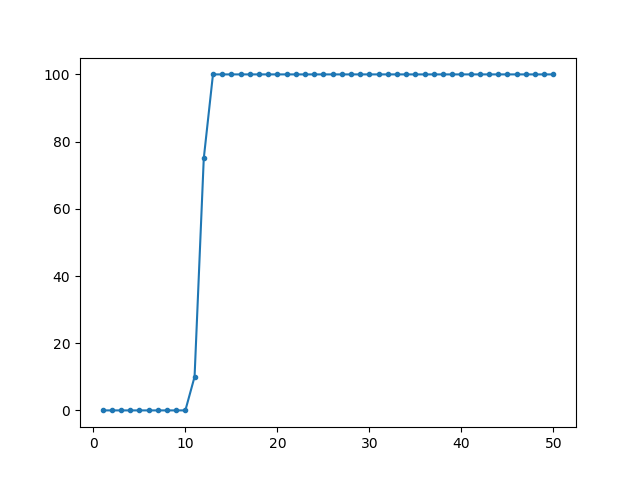

In [50]:

chip.set_idb_dacunits(0,1)
chip.write_conf()

for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)
    
injlist=np.arange(50,0,-1)
inj_low=chip.get_vl_dacunits()
cnt=np.empty(len(injlist))
print "inj all_hits hits aveToT"
for inj_i,inj in enumerate(injlist):
    chip.set_vh_dacunits(inj+inj_low,0)
    chip.write_conf()
    for _ in range(5):
        chip['fifo'].reset()
        time.sleep(0.002)
    chip.set_monoread()
    chip["inj"].start()
    while not chip['inj'].is_ready:
        time.sleep(0.001)
    time.sleep(0.2)
    x = chip['fifo'].get_data()
    ix = chip.interpret_data(x)
    ix_inj=ix[np.bitwise_and(ix["col"]==col,ix["row"]==row)]
    print inj,len(ix),len(ix_inj),np.average((ix_inj["te"]-ix_inj["le"]) & 0x3F)
    cnt[inj_i]=len(ix_inj)
plt.plot(injlist,cnt,".-")

## run threshold scan using injection_scan

2019-04-03 23:22:10,992 [INFO ] (MainThread) Initializing InjectionScan
2019-04-03 23:22:11,485 [INFO ] (MainThread) power status: {'VPC [V]': 0.8968192194291438, 'VDDA_DAC [mA]': 567.1670178167402, 'VDDP [V]': 1.7913174844533601, 'VDDD [V]': 1.7921228324974925, 'VDDA [mA]': 577.0899264452138, 'VPC [mA]': -0.32002818589178506, 'VDDD [mA]': 569.4866960087318, 'VPCSWSF [V]': 0.8973983967065867, 'VDDP [mA]': 575.548350884382, 'BiasSF [V]': 0.8971388147553919, 'VPCSWSF [mA]': -0.32130961215949544, 'VDDA [V]': 1.7921857260956175, 'VDDA_DAC [V]': 1.7915526135458166, 'BiasSF [mA]': -0.32389637762237766}
2019-04-03 23:22:11,570 [INFO ] (MainThread) Creating ZMQ context
2019-04-03 23:22:11,571 [INFO ] (MainThread) Creating socket connection to server tcp://127.0.0.1:5500
2019-04-03 23:22:11,573 [INFO ] (MainThread) ScanBase.start:data_send.data_send_init connected
2019-04-03 23:22:11,575 [INFO ] (MainThread) Resetting SRAM FIFO: size = 0
2019-04-03 23:22:12,022 [INFO ] (MainThread) Set timestam

0 30583 100.000% 1554326534.268s 8896hits 0errs
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
data (inj_n 100,inj_loop 50): INJ=5000 MONO=3896 MON=0
0 8896 100.000% 0.001s 3895hits 0errs
3895


<IPython.core.display.Javascript object>


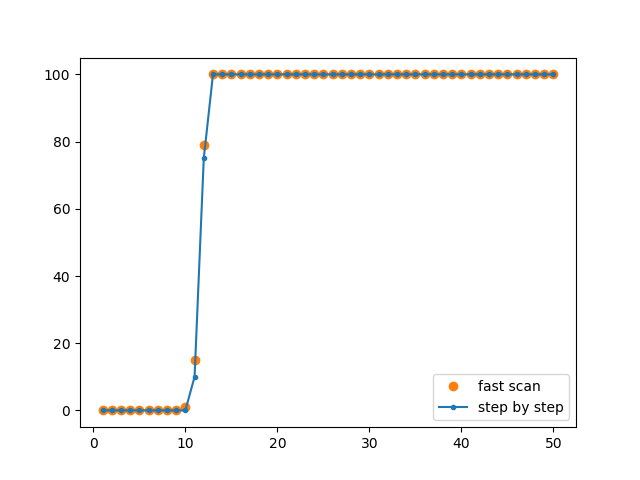

In [55]:

#chip.set_vh_dacunits(54,1)
#chip.set_idb_dacunits(0,1)

import tjmonopix.scans.injection_scan
reload(tjmonopix.scans.injection_scan)
scans=tjmonopix.scans.injection_scan.InjectionScan(dut=chip)

pix=[3,col,row]
#injlist=np.arange(73,0,-1)
thlist= None #np.arange(80,20,-1)
phaselist=None
output_filename=scans.start(
        pix=pix,
        injlist=injlist,thlist=thlist,phaselist=phaselist,
        with_mon=False,n_mask_pix=1,debug=2)

scans.analyze(output_filename)
fev=scans.output_filename[:-4]+"ev.h5"
with tb.open_file(fev) as f:
    hits=f.root.Hits[:]
print len(hits)

uni,u_cnt=np.unique(hits["inj"],return_counts=True)
data=np.zeros(len(injlist))
for u_i,u in enumerate(uni):
    a=np.argmin(np.abs(injlist-u))
    data[a]=u_cnt[u_i]
plt.plot(injlist,data,"C1o",label="fast scan")
plt.plot(injlist,cnt,"C0.-",label="step by step") ### step by step
plt.legend()

# Global TH scan

In [82]:
20.3439450687*10

203.43945068699998

2019-04-04 05:32:22,735 [INFO ] (MainThread) Initializing InjectionScan
2019-04-04 05:32:23,214 [INFO ] (MainThread) power status: {'VPC [V]': 0.8968192194291438, 'VDDA_DAC [mA]': 567.1670178167402, 'VDDP [V]': 1.7913174844533601, 'VDDD [V]': 1.7921228324974925, 'VDDA [mA]': 577.0899264452138, 'VPC [mA]': -0.32002818589178506, 'VDDD [mA]': 569.4866960087318, 'VPCSWSF [V]': 0.8973983967065867, 'VDDP [mA]': 575.548350884382, 'BiasSF [V]': 0.8971388147553919, 'VPCSWSF [mA]': -0.32130961215949544, 'VDDA [V]': 1.7921857260956175, 'VDDA_DAC [V]': 1.7915526135458166, 'BiasSF [mA]': -0.32389637762237766}
2019-04-04 05:32:23,295 [INFO ] (MainThread) Creating ZMQ context
2019-04-04 05:32:23,296 [INFO ] (MainThread) Creating socket connection to server tcp://127.0.0.1:5500
2019-04-04 05:32:23,297 [INFO ] (MainThread) ScanBase.start:data_send.data_send_init connected
2019-04-04 05:32:23,299 [INFO ] (MainThread) Resetting SRAM FIFO: size = 0
2019-04-04 05:32:23,767 [INFO ] (MainThread) Set timestam

0 11063 100.000% 1554348746.470s 3541hits 0errs
data (inj_n 100,inj_loop 31): INJ=3100 MONO=441 MON=0
0 3541 100.000% 0.001s 441hits 0errs
441 441
gl_th 4


<IPython.core.display.Javascript object>


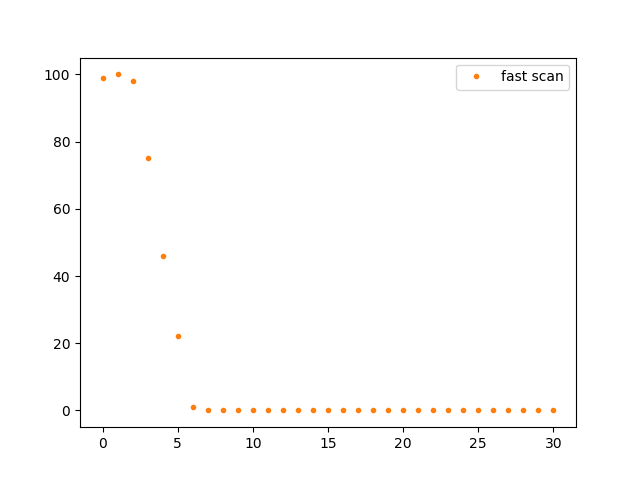

In [86]:
chip.set_vl_dacunits(40,0)
chip.set_vh_dacunits(10+40,0)
chip.write_conf()

for _ in range(5):
    chip['fifo'].reset()
    time.sleep(0.002)

thlist=np.arange(30,-1,-1)

## step by step 
if False:
    cnt=np.empty(len(thlist))
    print "inj all_hits hits aveToT"
    for th_i,th in enumerate(thlist):
        chip.set_idb_dacunits(th,0)
        chip.write_conf()
        for _ in range(5):
            chip['fifo'].reset()
            time.sleep(0.002)
        chip.set_monoread()
        chip["inj"].start()
        while not chip['inj'].is_ready:
            time.sleep(0.001)
        time.sleep(0.2)
        x = chip['fifo'].get_data()
        ix = chip.interpret_data(x)
        ix_inj=ix[np.bitwise_and(ix["col"]==col,ix["row"]==row)]
        print th,len(ix),len(ix_inj),np.average((ix_inj["te"]-ix_inj["le"]) & 0x3F)
        cnt[th_i]=len(ix_inj)
    plt.plot(thlist,cnt,"C0.-",label="step by step")
    
## fast scan
pix=[3,col,row]
injlist=None
#thlist=np.arange(80,20,-1)
phaselist=None
reload(tjmonopix.scans.injection_scan)
scans=tjmonopix.scans.injection_scan.InjectionScan(dut=chip)
output_filename=scans.start(
        pix=pix,
        injlist=injlist,thlist=thlist,phaselist=phaselist,
        with_mon=False,n_mask_pix=1,debug=2)

scans.analyze(output_filename)
fev=scans.output_filename[:-4]+"ev.h5"
with tb.open_file(fev) as f:
    hits=f.root.Hits[:]
print len(hits),
hits=hits[np.bitwise_and(hits["col"]==col,hits["row"]==row)]
print len(hits)

uni,u_cnt=np.unique(hits["th"],return_counts=True)
data=np.zeros(len(thlist))
for u_i,u in enumerate(uni):
    a=np.argmin(np.abs(thlist-u))
    data[a]=u_cnt[u_i]
gl_th=thlist[np.argmin(np.abs(data-50))]
print "gl_th",gl_th
plt.plot(thlist,data,"C1.",label="fast scan")
plt.legend()

# phase scan

2019-04-04 05:33:38,676 [INFO ] (MainThread) Initializing InjectionScan
2019-04-04 05:33:39,163 [INFO ] (MainThread) power status: {'VPC [V]': 0.8968192194291438, 'VDDA_DAC [mA]': 567.1670178167402, 'VDDP [V]': 1.7913174844533601, 'VDDD [V]': 1.7921228324974925, 'VDDA [mA]': 577.0899264452138, 'VPC [mA]': -0.32002818589178506, 'VDDD [mA]': 569.4866960087318, 'VPCSWSF [V]': 0.8973983967065867, 'VDDP [mA]': 575.548350884382, 'BiasSF [V]': 0.8971388147553919, 'VPCSWSF [mA]': -0.32130961215949544, 'VDDA [V]': 1.7921857260956175, 'VDDA_DAC [V]': 1.7915526135458166, 'BiasSF [mA]': -0.32389637762237766}
2019-04-04 05:33:39,247 [INFO ] (MainThread) Creating ZMQ context
2019-04-04 05:33:39,248 [INFO ] (MainThread) Creating socket connection to server tcp://127.0.0.1:5500
2019-04-04 05:33:39,249 [INFO ] (MainThread) ScanBase.start:data_send.data_send_init connected
2019-04-04 05:33:39,251 [INFO ] (MainThread) Resetting SRAM FIFO: size = 0
2019-04-04 05:33:39,700 [INFO ] (MainThread) Set timestam

0 33599 100.000% 1554348822.988s 9600hits 0errs
data (inj_n 100,inj_loop 48): INJ=4800 MONO=4800 MON=0
0 9600 100.000% 0.002s 4800hits 0errs
AnalyzeHits: le_cnts will be analyzed
toa [11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 12 12]
toa [100 100 100 100 100  99   1 100 100 100 100 100 100 100 100 100 100 100
 100 100]
AnalyzeLECnts: n of LECounts 50
save_best_phase() number of LEhist 1
========= save_best_phase() [18 25] phase=6 le=12


<IPython.core.display.Javascript object>


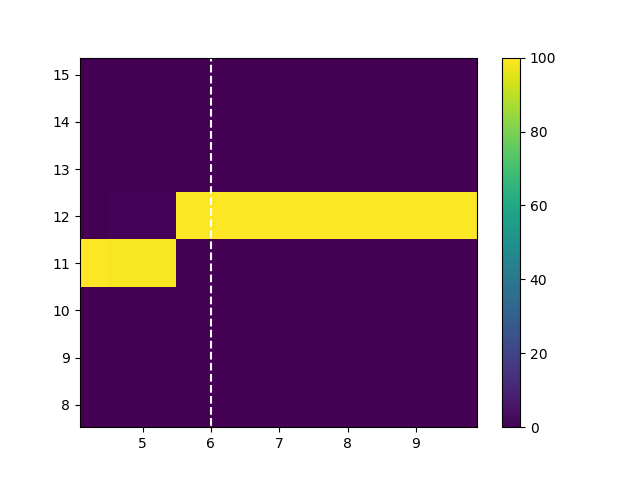

In [88]:
#gl_th=4 ## from gl_th scan
chip.set_vl_dacunits(40,0)
chip.set_vh_dacunits(80+40,0)
chip.set_idb_dacunits(gl_th,0)
chip.write_conf()

pix=[3,col,row]
injlist=None
thlist= None
phaselist=np.arange(0,48,1)
import tjmonopix.scans.injection_scan
reload(tjmonopix.scans.injection_scan)
scans=tjmonopix.scans.injection_scan.InjectionScan(dut=chip)
output_filename=scans.start(
        pix=pix,
        injlist=injlist,thlist=thlist,phaselist=phaselist,
        with_mon=False,n_mask_pix=1,debug=2)

scans.analyze(output_filename)
fev=scans.output_filename[:-4]+"ev.h5"
fraw=scans.output_filename+".h5"
import tjmonopix.analysis.analyze_hits as analyze_hits
ana=analyze_hits.AnalyzeHits(fev,fraw)
ana.init_hist_ev()
ana.init_cnts()
ana.init_le_hist()
ana.init_le_cnts()
ana.run()

import tjmonopix.analysis.analyze_le_cnts as analyze_le_cnts
ana=analyze_le_cnts.AnalyzeLECnts(fev,fraw)
ana.init_best_phase()
ana.run()
with tb.open_file(fev) as f:
    phase=f.root.BestPhase[0]["phase"]
with tb.open_file(fev) as f:
    hits=f.root.LEHist[:]
plt.imshow(np.transpose(hits[0]["LE"]),origin="bottom left",aspect="auto")
plt.plot([phase,phase],[0,63],"w--")
plt.ylim(0,63)
plt.colorbar()

In [90]:
#gl_th=4
#phase=6
chip.set_vl_dacunits(40,0)
chip.set_idb_dacunits(gl_th,0)
chip.write_conf()
chip["inj"].set_phase(phase)

import tjmonopix.scans.injection_scan
reload(tjmonopix.scans.injection_scan)
scans=tjmonopix.scans.injection_scan.InjectionScan(dut=chip)

pix=[3,col,row]
injlist=np.arange(1,80,1)
thlist= None #np.arange(80,20,-1)
phaselist=None
output_filename=scans.start(
        pix=pix,
        injlist=injlist,thlist=thlist,phaselist=phaselist,
        with_mon=False,n_mask_pix=1,debug=2)

scans.analyze(output_filename)
fev=scans.output_filename[:-4]+"ev.h5"
fraw=scans.output_filename+".h5"
import tjmonopix.analysis.analyze_hits as analyze_hits
reload(analyze_hits)
ana=analyze_hits.AnalyzeHits(fev,fraw)
ana.init_apply_ts_inj_window()
ana.init_delete_noninjected()
ana.init_hist_ev()
ana.init_cnts()
ana.init_le_hist()
ana.init_le_cnts()
ana.run()

import tjmonopix.analysis.analyze_cnts as analyze_cnts
ana=analyze_cnts.AnalyzeCnts(fev,fraw)
ana.init_scurve_fit()
ana.run()

import tjmonopix.analysis.analyze_le_cnts as analyze_le_cnts
reload(analyze_le_cnts)
ana=analyze_le_cnts.AnalyzeLECnts(fev,fraw)
ana.init_scurve_fit()
ana.run()

2019-04-04 05:37:09,840 [INFO ] (MainThread) Initializing InjectionScan
2019-04-04 05:37:10,329 [INFO ] (MainThread) power status: {'VPC [V]': 0.8968192194291438, 'VDDA_DAC [mA]': 567.1670178167402, 'VDDP [V]': 1.7913174844533601, 'VDDD [V]': 1.7921228324974925, 'VDDA [mA]': 577.0899264452138, 'VPC [mA]': -0.32002818589178506, 'VDDD [mA]': 569.4866960087318, 'VPCSWSF [V]': 0.8973983967065867, 'VDDP [mA]': 575.548350884382, 'BiasSF [V]': 0.8971388147553919, 'VPCSWSF [mA]': -0.32130961215949544, 'VDDA [V]': 1.7921857260956175, 'VDDA_DAC [V]': 1.7915526135458166, 'BiasSF [mA]': -0.32389637762237766}
2019-04-04 05:37:10,414 [INFO ] (MainThread) Creating ZMQ context
2019-04-04 05:37:10,415 [INFO ] (MainThread) Creating socket connection to server tcp://127.0.0.1:5500
2019-04-04 05:37:10,416 [INFO ] (MainThread) ScanBase.start:data_send.data_send_init connected
2019-04-04 05:37:10,418 [INFO ] (MainThread) Resetting SRAM FIFO: size = 0
2019-04-04 05:37:10,881 [INFO ] (MainThread) Set timestam

2019-04-04 05:37:14,477 [INFO ] (MainThread) Data queue size: 0
2019-04-04 05:37:14,485 [INFO ] (MainThread) SRAM FIFO size: 0
2019-04-04 05:37:14,491 [INFO ] (MainThread) Channel:                     TDC | DATA_RX | TLU | TIMESTAMP
2019-04-04 05:37:14,493 [INFO ] (MainThread) Discard counter:             None |       0 |   0 |         0
2019-04-04 05:37:14,998 [INFO ] (MainThread) Power status: {'VPC [V]': 0.8968192194291438, 'VDDA_DAC [mA]': 567.1670178167402, 'VDDP [V]': 1.7913174844533601, 'VDDD [V]': 1.7921228324974925, 'VDDA [mA]': 577.0899264452138, 'VPC [mA]': -0.32002818589178506, 'VDDD [mA]': 569.4866960087318, 'VPCSWSF [V]': 0.8973983967065867, 'VDDP [mA]': 575.548350884382, 'BiasSF [V]': 0.8971388147553919, 'VPCSWSF [mA]': -0.32130961215949544, 'VDDA [V]': 1.7921857260956175, 'VDDA_DAC [V]': 1.7915526135458166, 'BiasSF [mA]': -0.32389637762237766}
2019-04-04 05:37:15,075 [INFO ] (MainThread) Closing socket connection


0 51443 100.000% 1554349035.087s 14836hits 0errs
data (inj_n 100,inj_loop 79): INJ=7900 MONO=6936 MON=0
0 14836 100.000% 0.002s 6934hits 0errs
AnalyzeHits: le_cnts will be analyzed
AnalyzeLECnts: n of LECounts 74
### Fit scurves ###
79 13 11


/home/user/workspace/tjmonopix/tjmonopix_bell/tjmonopix/analysis/utils.py:77: RuntimeWarning: invalid value encountered in sqrt
  err=np.sqrt(np.diag(cov))


<IPython.core.display.Javascript object>


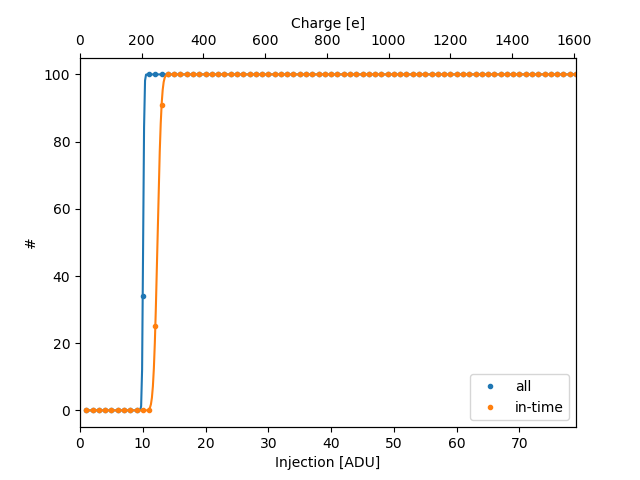

all mu 10.059 ADU (204.65 e) sigma 0.144 ADU (2.93 e)
intime mu 12.335 ADU (250.94 e) sigma 0.496 ADU (10.08 e)
over drive 2.275 ADU (46.29 e)


In [112]:
with tb.open_file(fev) as f:
    le=f.root.LECnts[:]
    le_fit=f.root.LEScurveFit[:]
    cnt=f.root.Cnts[:]
    cnt_fit=f.root.ScurveFit[:]
fig,ax=plt.subplots(1,1)
import tjmonopix.analysis.utils as utils
x=np.append(np.arange(1,np.min(cnt["inj"])),cnt["inj"])
y=np.append(np.zeros(len(x)-len(cnt["cnt"])),cnt["cnt"])
ax.plot(x,y,"C0.",label="all")
A=cnt_fit[0]["A"]
mu=cnt_fit[0]["mu"]
sigma=cnt_fit[0]["sigma"]
x,y=utils.scurve_from_fit(x,A_fit=A,mu_fit=mu,sigma_fit=sigma,reverse=False)
ax.plot(x,y,"C0-")
print "all mu %.3f ADU (%.2f e) sigma %.3f ADU (%.2f e)"%(mu,mu*CAPCAL,sigma,sigma*CAPCAL)

tmp=le[le["toa"]==12]
x=np.append(np.arange(1,np.min(tmp["inj"])),tmp["inj"])
y=np.append(np.zeros(len(x)-len(tmp["cnt"])),tmp["cnt"])
ax.plot(x,y,"C1.",label="in-time")
A=le_fit[le_fit["toa"]==12][0]["A"]
mu_in=le_fit[le_fit["toa"]==12][0]["mu"]
sigma_in=le_fit[le_fit["toa"]==12][0]["sigma"]
x,y=utils.scurve_from_fit(x,A_fit=A,mu_fit=mu_in,sigma_fit=sigma_in,reverse=False)
ax.plot(x,y,"C1-")
ax.set_xbound(0,np.max(cnt["inj"]))
ax2=ax.twiny()
ax2.set_xbound(0,np.max(cnt["inj"])*CAPCAL)
ax.set_xlabel("Injection [ADU]")
ax2.set_xlabel("Charge [e]")
ax.set_ylabel("#")
print "intime mu %.3f ADU (%.2f e) sigma %.3f ADU (%.2f e)"%(mu_in,mu_in*CAPCAL,sigma_in,sigma_in*CAPCAL)
print "over drive %.3f ADU (%.2f e)"%(mu_in-mu, (mu_in-mu)*CAPCAL)
ax.legend()